In [15]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

### Define functions for calculation

* MagneticMonopoleField(obsloc,poleloc=(0.,0.,0.),Q=1)
* VerticalMagneticLongDipoleLine(radius,L,stepsize=0.1,nstepmax=1000,dist_tol=0.5)
* MagneticLongDipoleLine(dipoleloc,dipoledec,dipoleinc,dipoleL,radii,Nazi=10)
* MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,obsloc,dipolemoment=1.)

In [16]:
def MagneticMonopoleField(obsloc,poleloc=(0.,0.,0.),Q=1):
    # relative obs. loc. to pole, assuming pole at origin
    dx, dy, dz = obsloc[0]-poleloc[0], obsloc[1]-poleloc[1], obsloc[2]-poleloc[2]
    r = np.sqrt(dx**2+dy**2+dz**2)
    Bx = Q * 1e-7 / r**2 * dx
    By = Q * 1e-7 / r**2 * dy
    Bz = Q * 1e-7 / r**2 * dz
    return Bx, By, Bz


def VerticalMagneticLongDipoleLine(radius,L,stepsize=0.1,nstepmax=1000,dist_tol=0.5):
    yloc, zloc = [radius], [0.]
    dist2pole = np.sqrt( yloc[0]**2 + (zloc[0]-L/2)**2 )
    # loop to get the lower half
    count = 1
    while (dist2pole > dist_tol) & (count<nstepmax):
        _, By1, Bz1 = MagneticMonopoleField((0.,yloc[-1],zloc[-1]),(0.,0.,L/2),Q=1)
        _, By2, Bz2 = MagneticMonopoleField((0.,yloc[-1],zloc[-1]),(0.,0.,-L/2),Q=-1)
        By, Bz = By1+By2, Bz1+Bz2
        B = np.sqrt(By**2 + Bz**2)
        By, Bz = By/B*stepsize, Bz/B*stepsize
        yloc = np.append(yloc, yloc[-1]+By)
        zloc = np.append(zloc, zloc[-1]+Bz)
        dist2pole = np.sqrt( yloc[-1]**2 + (zloc[-1]-L/2)**2 )
        count += 1
    # mirror to get the upper half
    yloc = np.append(yloc[-1:0:-1],yloc)
    zloc = np.append(-zloc[-1:0:-1],zloc)
    return yloc, zloc


def MagneticLongDipoleLine(dipoleloc,dipoledec,dipoleinc,dipoleL,radii,Nazi=10):
    x0, y0, z0 = dipoleloc[0], dipoleloc[1], dipoleloc[2]
    
    # rotation matrix
    theta, alpha = -np.pi*(dipoleinc+90.)/180., -np.pi*dipoledec/180.
    Rx = np.array([[1.,0.,0.],[0.,np.cos(theta),-np.sin(theta)],[0.,np.sin(theta),np.cos(theta)]])
    Rz = np.array([[np.cos(alpha),-np.sin(alpha),0.],[np.sin(alpha),np.cos(alpha),0.],[0.,0.,1.]])
    R = np.dot(Rz,Rx) # Rz @ Rx

    azimuth = np.linspace(0.,2*np.pi,num=Nazi,endpoint=False)
    xloc, yloc, zloc = [], [], []
    for r in radii:
        hloc, vloc = VerticalMagneticLongDipoleLine(r,dipoleL,stepsize=0.5)
        for a in azimuth:
            x, y, z = np.sin(a)*hloc, np.cos(a)*hloc, vloc
            xyz = R @ np.vstack((x,y,z))
            xloc.append(xyz[0]+x0)
            yloc.append(xyz[1]+y0)
            zloc.append(xyz[2]+z0)
    return xloc, yloc, zloc


def MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,obsloc,dipolemoment=1.):
    dec, inc, L = np.radians(dipoledec), np.radians(dipoleinc), dipoleL
    x1 = L/2 * np.cos(inc) * np.sin(dec) 
    y1 = L/2 * np.cos(inc) * np.cos(dec) 
    z1 = L/2 * -np.sin(inc)
    x2, y2, z2 = -x1, -y1, -z1
    Q = dipolemoment * 4e-7 * np.pi / L 
    Bx1, By1, Bz1 = MagneticMonopoleField(obsloc,(x1+dipoleloc[0],y1+dipoleloc[1],z1+dipoleloc[2]),Q=Q)
    Bx2, By2, Bz2 = MagneticMonopoleField(obsloc,(x2+dipoleloc[0],y2+dipoleloc[1],z2+dipoleloc[2]),Q=-Q)
    return Bx1+Bx2, By1+By2, Bz1+Bz2

### Define a magnetic dipole

A dipole is defined in the section below using
* dipoleloc: x, y, z location of the dipole center
* dipoledec: declination of the dipole's direction in degree; north = 0; positive clockwise
* dipoleinc: declination of the dipole's direction in degree; horizontal = 0; positive down
* dipoleL: length of the dipole *L* or the distance between two opposite charges *Q* that make the dipole
* dipolemoement: $m=\frac{QL}{\mu_0}$


In [17]:
# define a dipole
dipoleloc = (0.,0.,-1.)
dipoleL = 2.
dipoledec, dipoleinc = 0., 90.
dipolemoment = 1e13

### Define the Earth's magnetic field $B_0$
$B_0$ is used to calcualte the total field anomaly, which is the projection of the anomalous vector field onto the earth's field (inner product).
* B0: the magnitude of the earth's field
* Binc: inclination of the earth's field
* Bdec: declination of the earth's field

In [18]:
# geomagnetic field
B0, Binc, Bdec = 53600e-9, 90., 0. # in Tesla, degree, degree
B0x = B0*np.cos(np.radians(Binc))*np.sin(np.radians(Bdec))
B0y = B0*np.cos(np.radians(Binc))*np.cos(np.radians(Bdec))
B0z = -B0*np.sin(np.radians(Binc))

### Define the observations
Four data plots will be generated in the figure: magnetic anomalous field map (contour) at a certain elevation, magnetic anomalous field data (curve) along a x-profile and a y-profile, and the magnetic field lines of the dipole. 
* xmin, xmax, ymin, ymax: the outer bounds of the survey grid
* z: elevation at which the data map is measured
* profile_x, profile_y: x-coordinate of y-profile, y-coordinate of x-profile
* h: grid interval
* radii: how far the field lines expand; can plot multiple layers if given (r1, r2, ...)
* Nazi: number of azimuth angles for the field line

In [19]:
# set observation grid
xmin, xmax, ymin, ymax, z = -5., 5., -5., 5., 1. # x, y bounds and elevation
profile_x = 0. # x-coordinate of y-profile
profile_y = 0. # y-coordinate of x-profile
h = 0.2 # grid interval
radii = (2., 5.) # how many layers of field lines for plotting
Nazi = 10 # number of azimuth

### Calculate data for plotting

In [20]:
# get field lines
linex, liney, linez = MagneticLongDipoleLine(dipoleloc,dipoledec,dipoleinc,dipoleL,radii,Nazi)

# get map
xi, yi = np.meshgrid(np.r_[xmin:xmax+h:h], np.r_[ymin:ymax+h:h])
x1, y1 = xi.flatten(), yi.flatten()
z1 = np.full(x1.shape,z)
Bx, By, Bz = np.zeros(len(x1)), np.zeros(len(x1)), np.zeros(len(x1))
for i in np.arange(len(x1)):
    Bx[i], By[i], Bz[i] = MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,(x1[i],y1[i],z1[i]),dipolemoment)
Ba1 = np.dot(np.r_[B0x,B0y,B0z], np.vstack((Bx,By,Bz)) )

# get x-profile
x2 = np.r_[xmin:xmax+h:h]
y2, z2 = np.full(x2.shape,profile_y), np.full(x2.shape,z)
Bx, By, Bz = np.zeros(len(x2)), np.zeros(len(x2)), np.zeros(len(x2))
for i in np.arange(len(x2)):
    Bx[i], By[i], Bz[i] = MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,(x2[i],y2[i],z2[i]),dipolemoment)
Ba2 = np.dot( np.r_[B0x,B0y,B0z], np.vstack((Bx,By,Bz)) )

# get y-profile
y3 = np.r_[ymin:ymax+h:h]
x3, z3 = np.full(y3.shape,profile_x), np.full(y3.shape,z)
Bx, By, Bz = np.zeros(len(x3)), np.zeros(len(x3)), np.zeros(len(x3))
for i in np.arange(len(x3)):
    Bx[i], By[i], Bz[i] = MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,(x3[i],y3[i],z3[i]),dipolemoment)
Ba3 = np.dot( np.r_[B0x,B0y,B0z] , np.vstack((Bx,By,Bz)) )

### 3D plot of field lines and data
* Color bar in nT
* Spatial distance in meter
* Profile data only reflects shape of anomaly and positivity

<IPython.core.display.Javascript object>


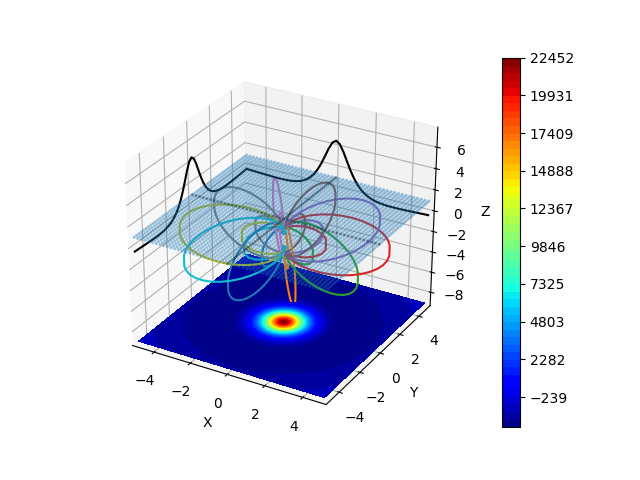

(-9.0, 7.5)

In [21]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# plot field lines
for lx,ly,lz in zip(linex,liney,linez):
    ax.plot(lx,ly,lz,'-',markersize=1)

# plot map
ax.scatter(x1,y1,z1,s=2,alpha=0.3)
Bt = Ba1.reshape(xi.shape)*1e9 # contour and color scale in nT 
c = ax.contourf(xi,yi,Bt,alpha=1,zdir='z',offset=z-max(radii)*2,cmap='jet',
                  levels=np.linspace(Bt.min(),Bt.max(),50,endpoint=True))
fig.colorbar(c)

# auto-scaling for profile plot
ptpmax = np.max((Ba2.ptp(),Ba3.ptp())) # dynamic range
autoscaling = np.max(radii) / ptpmax

# plot x-profile
ax.scatter(x2,y2,z2,s=2,c='black',alpha=0.3)
ax.plot(x2,Ba2*autoscaling,zs=ymax,c='black',zdir='y')

# plot y-profile
ax.scatter(x3,y3,z3,s=2,c='black',alpha=0.3)
ax.plot(y3,Ba3*autoscaling,zs=xmin,c='black',zdir='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_zlim(z-max(radii)*2, max(radii)*1.5)

